# Data Reduction and Transformation

In [1]:
import transformation_utils as utils
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler

In [2]:
df = pd.read_csv("../data/integrated.csv")
target = 'playoff'

## Eliminating Redundant Features 

In [3]:
df.drop(["round", "series", "tmIDWinner", "tmIDLoser", "W_series", "L_series", 'franchID', 'name', 'bioID', 'coachID',], axis=1, inplace=True)

## Feature Engineering

In [4]:
new_df = pd.DataFrame()
for year in df['year'].unique():
    for team in df['tmID'].unique():
        small_df = df[(df['tmID'] == team) & (df['year'] == year)]
        if small_df.empty:
            continue

        d = pd.DataFrame([small_df.iloc[0]])
        d.fillna(0, inplace=True)
        d['award_player'] = (small_df['award_player'].count())
        d['award_coach'] = d['award_coach'].apply(lambda i: 1 if i != 0 else 0)
        d['CBE_Sum'] = (small_df['CBE_Sum'].mean())
        d['height'] = (small_df['height'].mean())
        d['weight'] = (small_df['weight'].mean())
        d['playersAge'] = (2000 + df['year']) - utils.get_overall_age(small_df['birthDate'])
        d.drop('playerID', axis=1, inplace=True)
        d.drop('birthDate', axis=1, inplace=True)

        new_df = pd.concat([new_df, d])

df = new_df.sort_values(by=['year', 'tmID'])
df.drop(['tmID'], axis=1, inplace=True)

In [5]:
mapping = {'L': 1,
           'W': 1,
           'N': 0}

df['semis'] = df['semis'].map(mapping)
df['finals'] = df['finals'].map(mapping)
df['firstRound'] = df['firstRound'].map(mapping)

df['roundsPlayed'] = df['semis'] + df['finals'] + df['firstRound']
df.drop(['semis', 'finals', 'firstRound'], axis=1, inplace=True)

## Manual Feature Selection

In [6]:
utils.print_columns(df)
df.drop(['attend', 'arena', 'awayL', 'confL', "homeL", "d_oreb", "d_dreb", "o_oreb", "o_dreb", "L_team_post", "lost_team"], axis=1, inplace=True)

[ year, W_team_post, L_team_post, confID, rank, playoff, o_fgm, o_fga, o_ftm, o_fta, o_3pm, o_3pa, o_oreb, o_dreb, o_reb, o_asts, o_pf, o_stl, o_to, o_blk, o_pts, d_fgm, d_fga, d_ftm, d_fta, d_3pm, d_3pa, d_oreb, d_dreb, d_reb, d_asts, d_pf, d_stl, d_to, d_blk, d_pts, won_team, lost_team, GP, homeW, homeL, awayW, awayL, confW, confL, min, attend, arena, stint, won_coach, lost_coach, post_wins, post_losses, CBE_Sum, height, weight, award_player, award_coach, playersAge, roundsPlayed ]


In [7]:
# Assuming your DataFrame is named 'df'
# Define weights for each statistic
w1, w2, w3, w4 = 1, 0.8, 0.5, 0.7  # Adjust these weights based on your preferences

# Calculate ATR for each row
df['ATR'] = (w1 * (df['o_pts']) - df['d_pts']) + (w2 * (df['o_reb'] - df['d_reb'])) + (w3 * (df['o_asts'] - df['d_asts'])) + (w4 * (df['o_fgm'] - df['d_fgm']))

df.drop(['o_pts', 'o_reb', 'o_asts', 'o_fgm', 'd_pts', 'd_reb', 'd_asts', 'd_fgm'], axis=1, inplace=True)

## Feature Encoding

In [8]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])
df['confID'] = le.fit_transform(df['confID'])

key_cols = ['confID', 'year','playoff']
numerical_cols = [col for col in df.columns if col not in key_cols]

## Feature Scaling

In [9]:
scaler = RobustScaler()
normalizer = MinMaxScaler()

df[numerical_cols] = scaler.fit_transform(df.drop(key_cols, axis=1))
df[numerical_cols] = normalizer.fit_transform(df.drop(key_cols, axis=1))
df.head()

,year,W_team_post,confID,rank,playoff,o_fga,o_ftm,o_fta,o_3pm,o_3pa,...,post_wins,post_losses,CBE_Sum,height,weight,award_player,award_coach,playersAge,roundsPlayed,ATR
119,2,0.000000,0,1.000000,1,0.218792,0.292537,0.261501,0.312217,0.303183,...,0.000000,0.0,0.316584,0.262097,0.330043,0.000000,0.0,0.440079,0.000000,0.255930
206,2,0.428571,0,0.142857,1,0.118121,0.277612,0.244552,0.357466,0.338358,...,0.428571,0.6,0.452861,0.395161,0.625732,0.000000,0.0,0.261297,0.666667,0.651684
372,2,0.000000,0,0.571429,0,0.322148,0.555224,0.556901,0.063348,0.113903,...,0.000000,0.0,0.147339,0.383065,0.337606,0.000000,0.0,0.385069,0.000000,0.450269
202,2,0.857143,1,0.142857,1,0.206711,0.561194,0.399516,0.497738,0.479062,...,0.857143,0.0,0.110306,0.410557,0.476134,0.333333,0.0,0.706376,1.000000,1.000000
258,2,0.000000,0,0.857143,0,0.131544,0.283582,0.242131,0.592760,0.529313,...,0.000000,0.0,0.322328,0.415633,0.436789,0.000000,0.0,0.329001,0.000000,0.431374


## Grid Search for SelectKBest and PCA

In [10]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(batch_size=8, max_iter=10000, random_state=42)
#results = utils.grid_search_features(df, key_cols, target, clf, 10)
#utils.display_num_features_results(results)

## Feature Selection

In [11]:
n_features = 16
n_components = 6

In [12]:
initial = df.columns
df = utils.select_features(df, target, key_cols, n_features)

print("Removed: ", set(initial) - set(df.columns))

Removed:  {'o_to', 'd_3pa', 'd_stl', 'o_ftm', 'min', 'o_3pm', 'd_fga', 'o_pf', 'd_ftm', 'weight', 'GP', 'o_3pa', 'height', 'o_stl', 'd_to', 'homeW', 'd_pf', 'd_3pm', 'd_fta', 'o_fta', 'o_blk', 'award_coach', 'd_blk'}


## Feature Aggregation

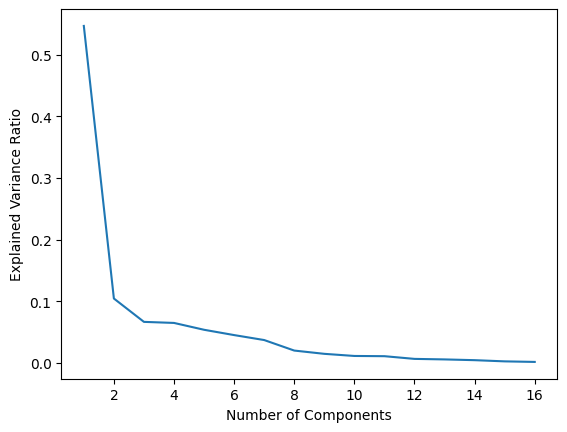

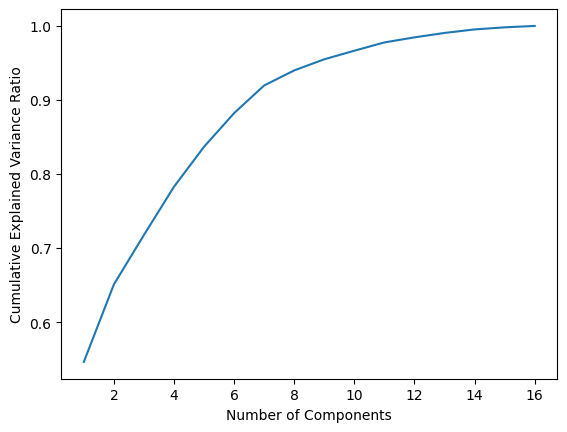

In [13]:
utils.plot_pca(df.drop(key_cols, axis=1))

In [14]:
old_df = df.copy()
df = utils.feature_aggregation_pca(df, n_components, key_cols)
utils.print_columns(df)

[ PC1, PC2, PC3, PC4, PC5, PC6, confID, year, playoff ]


## Checking for Correlation

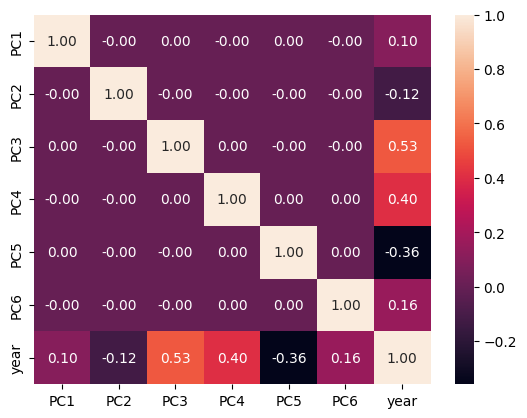

<Figure size 14400x14400 with 0 Axes>

In [15]:
key_cols.remove("year")
utils.plot_correlation(df.drop(key_cols, axis=1))


## Checking for null values

In [16]:
print("Number of null values: ", df.isnull().sum().sum())

Number of null values:  0


# Saving the data

In [17]:
df.to_csv("../data/transformed.csv", index=False)